In [1]:
# Author: Jaehun Kim
# Email: rlawogns1204@unist.ac.kr
# Affiliation: UNIST BME BCILAB
# Date: 2023-06-12
#
# This code implements a tactile information processing model using a spiking
# neural network (SNN). It simulates the processing of tactile information from
# mechanoreceptors in the skin through primary afferent fibers (PA), cuneate nucleus
# neurons (PN and IN), and ultimately, somatosensory cortex neurons. The model
# incorporates lateral inhibition and various receptive field properties to
# represent a realistic processing of touch stimuli.

# with DIGIT-sensor
# pip install torch==1.8.1+cu101 torchvision==0.9.1+cu101 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io
import time
import numpy as np
from PIL import Image
import io
import datetime
import cv2
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

from Function.snn_IZHIlayers import *
from Function.snn_plot import *
from Function.snn_simulation import *
from Function.snn_stimulation import *
from Function.snn_receptive_field_weights import *

from line_profiler import LineProfiler

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Check if GPU is available and print the CUDA version
print(f"GPU available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
# Enable GPU support if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the device to 'cpu'
device = 'cpu'
print(f"Using device: {device}")
# Start of the SNN (Spiking Neural Network) code

GPU available: False
CUDA version: None
Using device: cpu


In [3]:
# Set sensor dimensions (height and width in millimeters)
sensor_h, sensor_w = 19, 16
# Set pixel dimensions (number of pixels in height and width)
# pixel_h, pixel_w = 320, 240///
pixel_h, pixel_w = 64,48
# Set image frames per second (FPS) of tactile sensor
image_FPS = 60

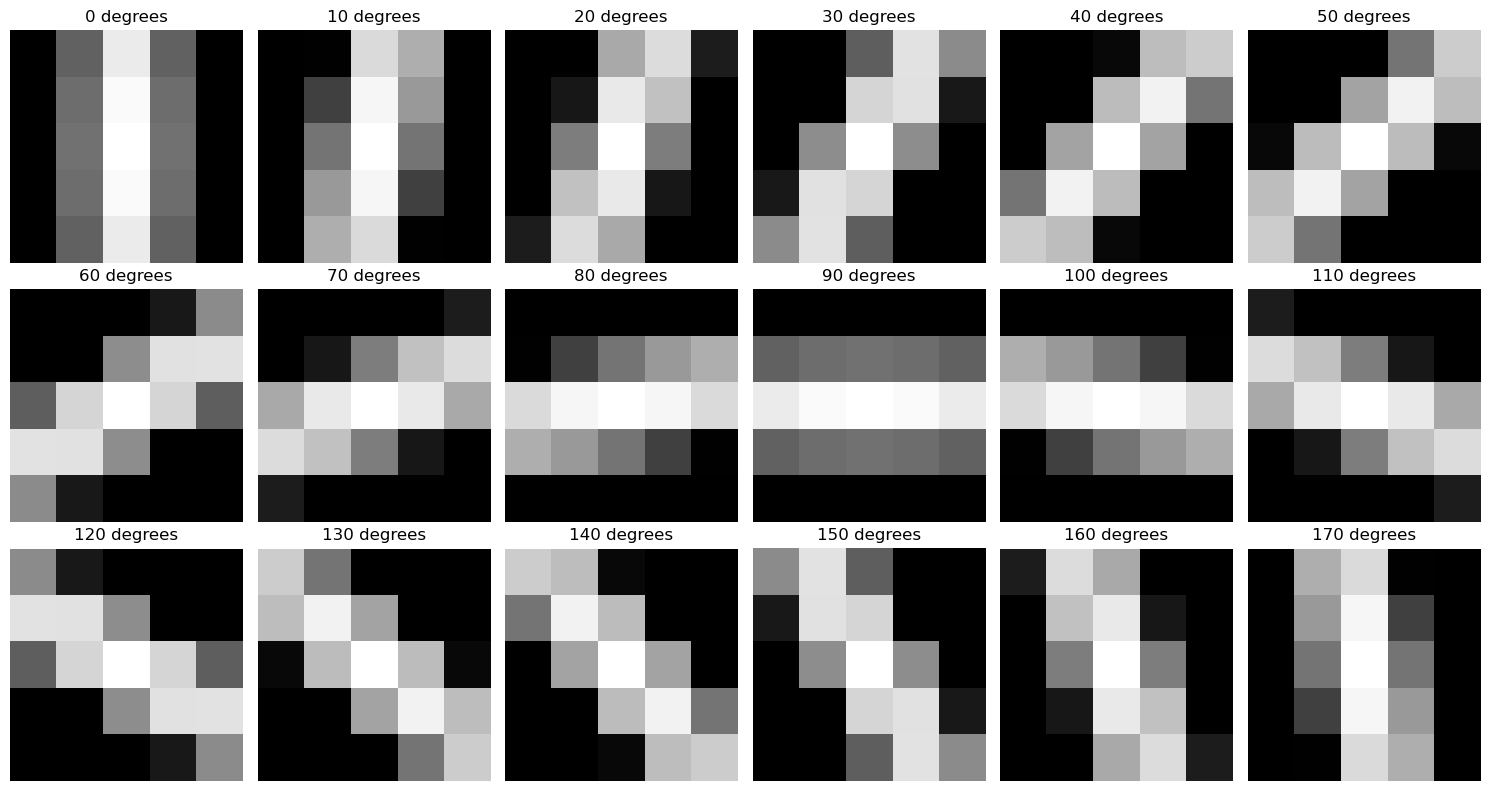

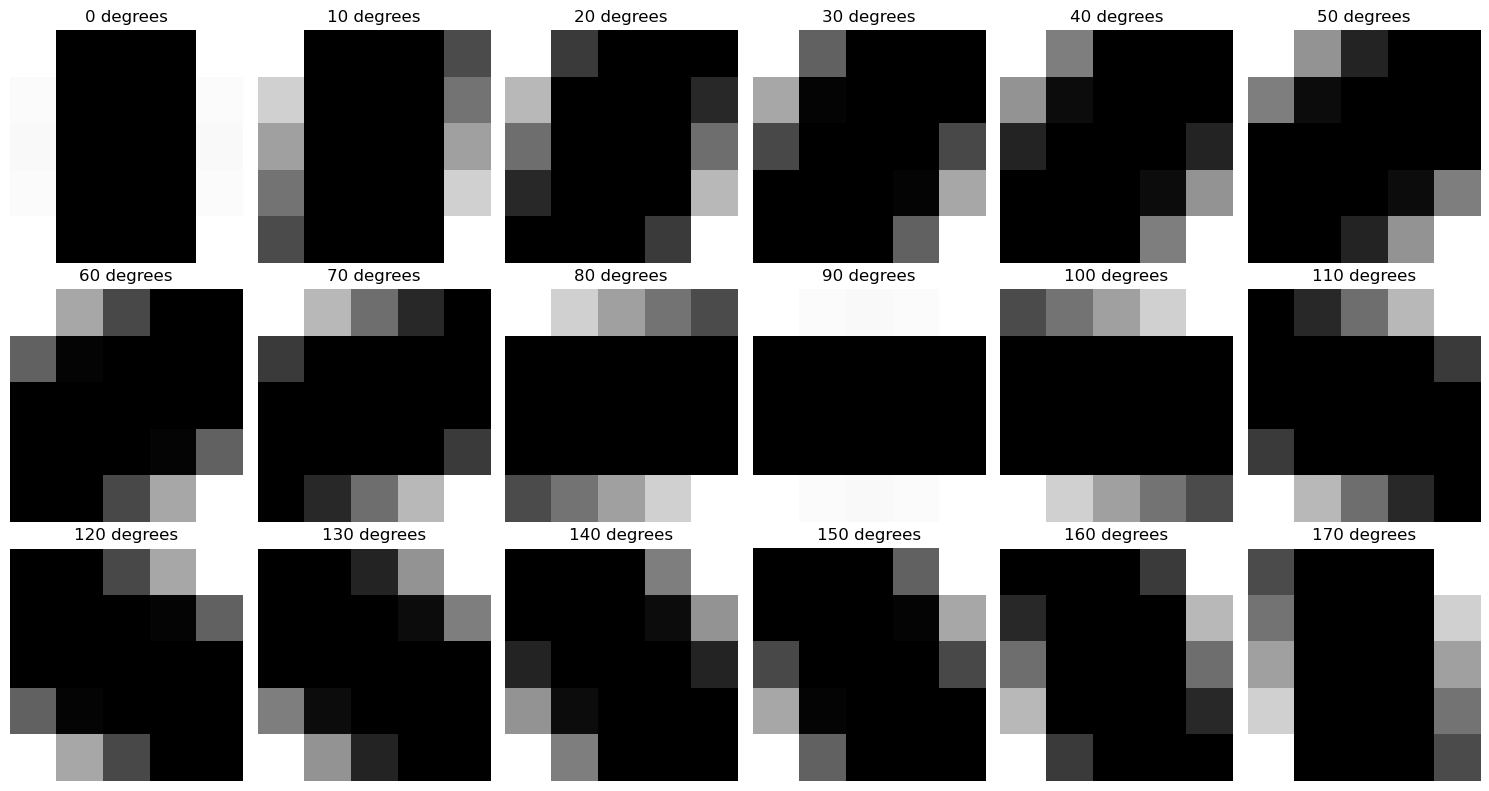

tensor([[0.0000, 0.0000, 0.7525, 0.9825, 0.1281],
        [0.0000, 0.1050, 1.0393, 0.8633, 0.0000],
        [0.0000, 0.5595, 1.1395, 0.5595, 0.0000],
        [0.0000, 0.8633, 1.0393, 0.1050, 0.0000],
        [0.1281, 0.9825, 0.7525, 0.0000, 0.0000]])
tensor([[1.9676, 0.4471, 0.0000, 0.0000, 0.0000],
        [1.4219, 0.0000, 0.0000, 0.0000, 0.3135],
        [0.8500, 0.0000, 0.0000, 0.0000, 0.8500],
        [0.3135, 0.0000, 0.0000, 0.0000, 1.4219],
        [0.0000, 0.0000, 0.0000, 0.4471, 1.9676]])


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

def generate_gabor_kernels(ksize, theta_range):
    kernels_pos = []
    kernels_neg = []
    kernels_twos = []

    for theta in theta_range:
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        kern -= np.mean(kern)  # Set the center value to 0
        kern /= np.abs(kern).sum()
        kern *= 20  # Adjust weight to maintain the same total sum

        pos = torch.tensor(np.maximum(0, kern), dtype=torch.float32)
        neg = torch.tensor(np.maximum(0, -kern), dtype=torch.float32)
        twos = torch.tensor(np.full_like(kern, 2), dtype=torch.float32)

                    # Zero out one half of the 'negative' kernel
        # mid_point = neg.shape[1] // 2
        # neg[:, :mid_point] = 0

        kernels_pos.append(pos)
        kernels_neg.append(neg)
        kernels_twos.append(twos)

    return kernels_pos, kernels_neg, kernels_twos

ksize = 5
theta_range = np.arange(np.pi, np.pi*2 , np.pi / 18)

kernels_pos, kernels_neg, kernels_twos = generate_gabor_kernels(ksize, theta_range)

fig, axs = plt.subplots(3, 6, figsize=(15, 8))

for i, ax in enumerate(axs.flatten()):
    if i < len(kernels_pos):
        ax.imshow(kernels_pos[i], cmap='gray')
        ax.set_title(f"{(i*10)} degrees")
        ax.axis('off')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3, 6, figsize=(15, 8))

for i, ax in enumerate(axs.flatten()):
    if i < len(kernels_neg):
        ax.imshow(kernels_neg[i], cmap='gray')
        ax.set_title(f"{(i*10)} degrees")
        ax.axis('off')

plt.tight_layout()
plt.show()

print(kernels_pos[2])
print(kernels_neg[2])


angle0to180
torch.Size([88, 3072])
sa_rf shape: torch.Size([88, 3072]) with height = 11 with width = 8
ra_rf shape: torch.Size([130, 3072]) with height = 13 with width = 10
sa_cn_pn_rf shape:  torch.Size([54, 88]) sa_cn_pn_step_height: 9 sa_cn_pn_step_width: 6
sa_cn_in_rf shape:  torch.Size([54, 88]) sa_cn_in_step_height: 9 sa_cn_in_step_width: 6
ra_cn_pn_rf shape:  torch.Size([88, 130]) ra_cn_pn_step_height: 11 ra_cn_pn_step_width: 8
ra_cn_in_rf shape:  torch.Size([88, 130]) ra_cn_in_step_height: 11 ra_cn_in_step_width: 8
sa_intopn_rf shape:  torch.Size([54, 54])
ra_intopn_rf shape:  torch.Size([88, 88])
cn_pn_sa_rf shape:  torch.Size([504, 54]) cn_pn_sa_rf_step_height: 7 cn_pn_sa_rf_step_width: 4
cn_in_sa_rf shape:  torch.Size([504, 54]) cn_in_sa_rf_step_height: 7 cn_in_sa_rf_step_width: 4
cn_pn_ra_rf shape:  torch.Size([504, 88]) cn_pn_ra_rf_step_height: 7 cn_pn_ra_rf_step_width: 4
cn_in_ra_rf shape:  torch.Size([504, 88]) cn_in_ra_rf_step_height: 7 cn_in_ra_rf_step_width: 4
cn_into

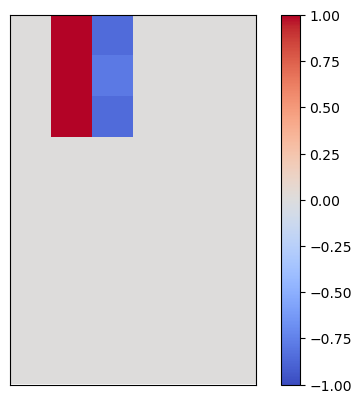

tensor(7.5000)


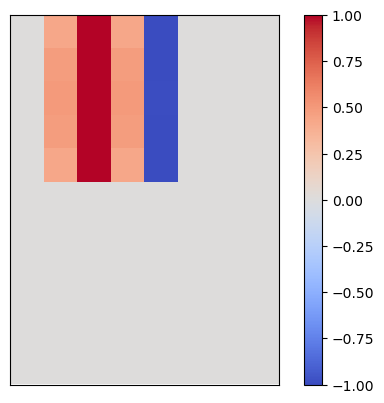

tensor(5.0000)


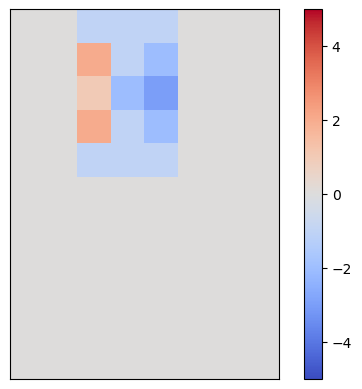

tensor(-12.)


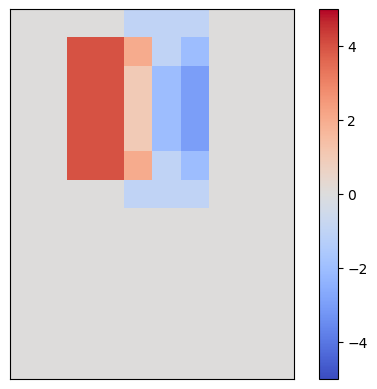

tensor(20.)


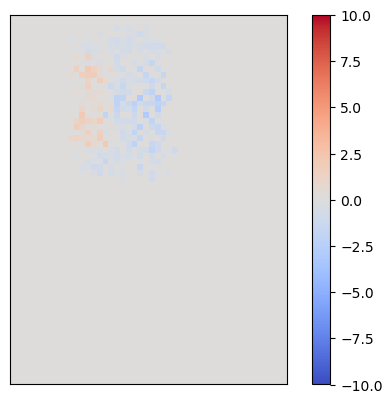

tensor(-111.6948) tensor(261.0746)


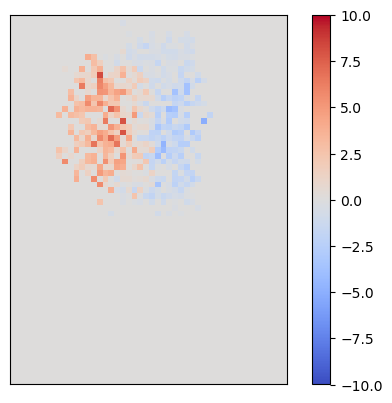

tensor(-111.6948) tensor(261.0746)


In [5]:
R = ReceptiveFieldWeights(pixel_h, pixel_w, device, type_output='angle0to180', plot_receptive_field= True)

In [ ]:
num_stim = 100
F = 2
pixel_h = 64
pixel_w = 48
device = 'cpu'

stimuli = {}

plt.rcParams['font.size'] = 20
fig_size = (30, 6)
line_lengths = 0.6

for angle in range(0, 181, 50):
    print('angle:', angle)

    stimulus = generate_stimuli(angle, num_stim, pixel_h, pixel_w, F=F, plot_stimuli=True, device=device)
    stimuli[angle] = stimulus

    S = SNN(R, device=device, noise_std_val=0)
    S.feedforward(stimulus)

    mean_firing_rates = plot_SNN(S,layers = ['sa','cn'],plot_figure = True, fig_size = fig_size)

    max_rate, max_index = torch.max(mean_firing_rates, dim=0)
    rate_range = max_index // 18

    print(max_index)
    # for i in range(18):
    #     if i * 18 <= max_index < (i + 1) * 18:
    #         print("The maximum rate index falls in the range:", i * 18, "-", (i + 1) * 18 - 1)
    #         break

In [16]:
##DATA
# 0 to 170

num_trials = 20
num_angles = range(0, 180, 5)  # Angles from 0 to 170 degrees
num_stim = 200
F = 5
pixel_h = 64
pixel_w = 48
device = 'cpu'  # Or your device of choice
data = []
labels = []

# Run the trials
for trial in range(num_trials):
    # Generate the stimuli for each angle
    for angle in num_angles:
        # Generate the stimulus
        stimulus = generate_stimuli(angle, num_stim, pixel_h, pixel_w, F=F, plot_stimuli=False, device=device)
        
        S = SNN(R, device = device, noise_std_val = 4)
        S.feedforward(stimulus)
        mean_firing_rates = plot_SNN(S,plot_figure = False)

        # Save the data and labels
        data.append(mean_firing_rates.cpu().numpy())
        labels.append(angle)


KeyboardInterrupt: 

In [18]:
from tqdm import tqdm

num_trials = 20
num_angles = range(0, 180, 5)  # Angles from 0 to 170 degrees
num_stim = 200
F = 5
pixel_h = 64
pixel_w = 48
device = 'cpu'  # Or your device of choice
data = []
labels = []


# Run the trials
for trial in tqdm(range(num_trials), desc="Trials"):
    # Generate the stimuli for each angle
    for angle in tqdm(num_angles, desc=f"Trial {trial+1} - Angles", leave=False):
        # Generate the stimulus
        stimulus = generate_stimuli(angle, num_stim, pixel_h, pixel_w, F=F, plot_stimuli=False, device=device)
        
        S = SNN(R, device = device, noise_std_val = 4)
        S.feedforward(stimulus)
        mean_firing_rates = plot_SNN(S,plot_figure = False)

        # Save the data and labels
        data.append(mean_firing_rates.cpu().numpy())
        labels.append(angle)

Trials: 100%|██████████| 20/20 [32:49<00:00, 98.48s/it]


In [20]:
# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

np.save('data_svm_angle.npy', data)
np.save('labels_svm_angle.npy', labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Create and train the SVM
clf = svm.SVC(kernel='linear')  # You can change the kernel as needed
clf.fit(X_train, y_train)

# Test the SVM
y_pred = clf.predict(X_test)

# Print the accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# print(X_train.shape)
# print(X_test.shape)
# print(y_train)
# print(y_test)

# Identify the misclassified samples
misclassified = np.where(y_test != y_pred)

# Print the misclassified labels
print("Misclassified labels               : ", y_test[misclassified])
print("Test output of misclassified labels: ", y_pred[misclassified])
# Print the indices of the misclassified samples
# print("Indices of misclassified samples: ", misclassified)

Accuracy: 1.0
Misclassified labels               :  []
Test output of misclassified labels:  []


In [ ]:
num_stim = 1000
F = 10
pixel_h = 64
pixel_w = 48
device = 'cpu'  # Or your device of choice

# Create a dictionary to store the stimuli
stimuli = {}

# Generate the stimuli for each angle from 0 to 180 degrees
for angle in range(0, 181, 10):
    print('angle: ',angle)
    # Generate the stimulus
    stimulus = generate_stimuli(angle, num_stim, pixel_h, pixel_w, F=F, plot_stimuli=True, device=device)
    
    # Add the stimulus to the dictionary
    stimuli[angle] = stimulus

    S = SNN(R, device = device, noise_std_val = 0)
    S.feedforward(stimulus)

    mean_firing_rates = plot_SNN(S)

